# Project 2: Supervised Learning
### Building a Student Intervention System

## 1. Classification vs Regression

Your goal is to identify students who might need early intervention - which type of supervised machine learning problem is this, classification or regression? Why?

Classification. We want to label each student to be either needs intervention or doesn't need, so it's a binary classification problem.

## 2. Exploring the Data

Let's go ahead and read in the student dataset first.

_To execute a code cell, click inside it and press **Shift+Enter**._

In [1]:
# Import libraries
import numpy as np
import pandas as pd

In [2]:
# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"
# Note: The last column 'passed' is the target/label, all other are feature columns

Student data read successfully!


Now, can you find out the following facts about the dataset?
- Total number of students
- Number of students who passed
- Number of students who failed
- Graduation rate of the class (%)
- Number of features

_Use the code block below to compute these values. Instructions/steps are marked using **TODO**s._

In [3]:
# TODO: Compute desired values - replace each '?' with an appropriate expression/function call
n_students = len(student_data.index)
n_features = len(student_data.columns) - 1
#print student_data.loc[[2]]
n_passed = len(student_data[student_data.passed == "yes"])
n_failed = len(student_data[student_data.passed == "no"])
grad_rate = n_passed * 1.0 / n_students
print "Total number of students: {}".format(n_students)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Number of features: {}".format(n_features)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of students who passed: 265
Number of students who failed: 130
Number of features: 30
Graduation rate of the class: 0.67%


## 3. Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Let's first separate our data into feature and target columns, and see if any features are non-numeric.<br/>
**Note**: For this dataset, the last column (`'passed'`) is the target or label we are trying to predict.

In [4]:
# Extract feature (X) and target (y) columns
feature_cols = list(student_data.columns[:-1])  # all columns but last are features
target_col = student_data.columns[-1]  # last column is the target/label
print "Feature column(s):-\n{}".format(feature_cols)
print "Target column: {}".format(target_col)
X_all = student_data[feature_cols]
y_all = student_data[target_col]  # corresponding targets/labels
print "\nFeature values:-"
print X_all.head()  # print the first 5 rows

Feature column(s):-
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Target column: passed

Feature values:-
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...    

### Preprocess feature columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [5]:
# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'school' => 'school_GP', 'school_MS'

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

X_all = preprocess_features(X_all)
print "Processed feature columns ({}):-\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48):-
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Split data into training and test sets

So far, we have converted all _categorical_ features into numeric values. In this next step, we split the data (both features and corresponding labels) into training and test sets.

In [33]:
# First, decide how many training vs test samples you want
num_all = student_data.shape[0]  # same as len(student_data)
num_train = 300  # about 75% of the data
num_test = num_all - num_train

# Then, select features (X) and corresponding labels (y) for the training and test sets
# Note: Shuffle the data or randomly select samples to avoid any bias due to ordering in the dataset
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = num_test, random_state = 42)
print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])
# Note: If you need a validation set, extract it from within training data

Training set: 300 samples
Test set: 95 samples


## 4. Training and Evaluating Models
Choose 3 supervised learning models that are available in scikit-learn, and appropriate for this problem. For each model:

- What is the theoretical O(n) time & space complexity in terms of input size?
- What are the general applications of this model? What are its strengths and weaknesses?
- Given what you know about the data so far, why did you choose this model to apply?
- Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.

Produce a table showing training time, prediction time, F<sub>1</sub> score on training set and F<sub>1</sub> score on test set, for each training set size.

Note: You need to produce 3 such tables - one for each model.

### 4.1 SVM
1. What is the theoretical O(n) time & space complexity in terms of input size?

   [Time complexity grows between like $n^2$ and $n^3$. Empirical evidence shows that modern SVM solvers come close to these scaling laws.](https://www.csie.ntu.edu.tw/~cjlin/papers/bottou_lin.pdf)

   Space compexity depends on how many support vectors in the final model. SVM is a nonparametric mehod which needs to retain training examples and potentially need to store them all.

2. What are the general applications of this model? What are its strengths and weaknesses?
   SVM can be applied to categorization and classification.

   Strengths:
   - Using Kernel trick to fit nonlinear data
   - No local optimal, unlike in neural networks
   - It scales relatively well to high dimensional data
   - Tradeoff between classifier complexity and error can be controlled explicitly
   - Non-traditional data like strings((string kernal)[https://en.wikipedia.org/wiki/String_kernel] )and trees((tree kernal)[http://papers.nips.cc/paper/2089-convolution-kernels-for-natural-language.pdf]) can be used as input to SVM, instead of feature vectors.
   
   weaknesses:
   - Requires full labeling of input data, which means the training data should include at least one positive and one negative categories.
   - Uncalibrated class membership probabilities, which means svm gives an answer for classification, but gives poor (probability estimates)[https://en.wikipedia.org/wiki/Platt_scaling]. On the contrast, for example, Naive Bayes Model can give a prediction of label and a degree of certainty about the answer(the posterior probability)
   - If the number of features is much greater than the number of samples, the method is likely to give poor performances.
   - The SVM is only directly applicable for two-class tasks. Therefore, algorithms that reduce the multi-class task to several binary problems have to be applied;
   - Parameters of a solved model are difficult to interpret. Which means it's hard to tell the relationship between the feature weights we got with corresponded features, expecially when using kernels. On the contrast, decision tree model can tell which feature is more important.
   
   references: [rutgers](http://www.cs.rutgers.edu/~mlittman/courses/ml04/svm.pdf)
   [wiki](https://en.wikipedia.org/wiki/Support_vector_machine)
   [ntu](https://www.csie.ntu.edu.tw/~cjlin/papers/bottou_lin.pdf)
               


3. Given what you know about the data so far, why did you choose this model to apply?

   I'm not sure the data is linearly separable, so I want to try SVM first. The performance will tell me if it's linearly separable.

In [7]:
# Train a model
import time

def train_classifier(clf, X_train, y_train):
    print "Training {}...".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    print "Done!\nTraining time (secs): {:.3f}".format(end - start)

# Choose a model, import it and instantiate an object
from sklearn.svm import SVC
clf = SVC()

# Fit model to training data
train_classifier(clf, X_train, y_train)  # note: using entire training set here

Training SVC...
Done!
Training time (secs): 0.011
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [8]:
# Predict on training set and compute F1 score
from sklearn.metrics import f1_score

def predict_labels(clf, features, target):
    print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    print "Done!\nPrediction time (secs): {:.3f}".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')

train_f1_score = predict_labels(clf, X_train, y_train)
print "F1 score for training set: {}".format(train_f1_score)

Predicting labels using SVC...
Done!
Prediction time (secs): 0.007
F1 score for training set: 0.876068376068


In [9]:
# Predict on test data
print "F1 score for test set: {}".format(predict_labels(clf, X_test, y_test))

Predicting labels using SVC...
Done!
Prediction time (secs): 0.003
F1 score for test set: 0.783783783784


In [13]:
# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test):
    print "------------------------------------------"
    print "Training set size: {}".format(len(X_train))
    train_classifier(clf, X_train, y_train)
    print "F1 score for training set: {}".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {}".format(predict_labels(clf, X_test, y_test))

# Run the helper function above for desired subsets of training data
sizes = np.round(np.linspace(100, len(X_train), 3))

for s in sizes:
    train_predict(clf, X_train[:int(s)], y_train[:int(s)], X_test, y_test)
# Note: Keep the test set constant

------------------------------------------
Training set size: 100
Training SVC...
Done!
Training time (secs): 0.003
Predicting labels using SVC...
Done!
Prediction time (secs): 0.002
F1 score for training set: 0.877697841727
Predicting labels using SVC...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.774647887324
------------------------------------------
Training set size: 200
Training SVC...
Done!
Training time (secs): 0.004
Predicting labels using SVC...
Done!
Prediction time (secs): 0.003
F1 score for training set: 0.867924528302
Predicting labels using SVC...
Done!
Prediction time (secs): 0.002
F1 score for test set: 0.781456953642
------------------------------------------
Training set size: 300
Training SVC...
Done!
Training time (secs): 0.011
Predicting labels using SVC...
Done!
Prediction time (secs): 0.006
F1 score for training set: 0.876068376068
Predicting labels using SVC...
Done!
Prediction time (secs): 0.002
F1 score for test set: 0.783783783784


**training data size** | **training time** | **prediction time** | **F1 score on training set** | **F1 score on test set**
---------------- | ---------------- | ---------------------| ------------------------ | --------------------
100 | 0.002 | 0.001 | 0.877697841727 | 0.781456953642
200 | 0.006 | 0.001 | 0.867924528302 | 0.781456953642
300 | 0.009 | 0.002 | 0.876068376068 | 0.783783783784

### 4.2 AdaBoost
1. What is the theoretical O(n) time & space complexity in terms of input size?

   Time complexity: assume we use K decition stumps, the complexity should be O(Kn).

   Space compexity: O(1) since with only need to store a vector of K hypotheses and a vector of K hypotheses weights.

2. What are the general applications of this model? What are its strengths and weaknesses?
   SVM can be applied to categorization and classification.

   Strengths:
   - Very simple to implement, expecially when using decision stumps. On the contrast, SVM needs a quadratic programming library.
   - Feature selection on very large sets of features.
   - Less parameters to tune. When using decision stump, only need to tune the number of hypotheses. 
   
   weaknesses:
   - From empirical evidence, AdaBoost is particularly vulnerable to uniform noise.
   - Weak classifiers too complex leads to overfitting.
   - Weak classifiers too weak can lead to low margins, and can also lead to overfitting.
   
   
   references: [1](http://www.robots.ox.ac.uk/~az/lectures/cv/adaboost_matas.pdf)
   [2](http://math.mit.edu/~rothvoss/18.304.3PM/Presentations/1-Eric-Boosting304FinalRpdf.pdf)
   


3. Given what you know about the data so far, why did you choose this model to apply?

   SVM doesn't gives a very decent F1 score, so I want to try on nonlinear classification algorithm like AdaBoost with desicion stump.

In [34]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=200)
# Fit model to training data
train_classifier(bdt, X_train, y_train)  # note: using entire training set here
train_f1_score = predict_labels(bdt, X_train, y_train)
print "F1 score for training set: {}".format(train_f1_score)
print "F1 score for test set: {}".format(predict_labels(bdt, X_test, y_test))

Training AdaBoostClassifier...
Done!
Training time (secs): 0.546
Predicting labels using AdaBoostClassifier...
Done!
Prediction time (secs): 0.030
F1 score for training set: 0.864864864865
Predicting labels using AdaBoostClassifier...
Done!
Prediction time (secs): 0.020
F1 score for test set: 0.781954887218


In [15]:
for s in sizes:
    train_predict(bdt, X_train[:int(s)], y_train[:int(s)], X_test, y_test)

------------------------------------------
Training set size: 100
Training AdaBoostClassifier...
Done!
Training time (secs): 0.497
Predicting labels using AdaBoostClassifier...
Done!
Prediction time (secs): 0.019
F1 score for training set: 0.933333333333
Predicting labels using AdaBoostClassifier...
Done!
Prediction time (secs): 0.017
F1 score for test set: 0.766917293233
------------------------------------------
Training set size: 200
Training AdaBoostClassifier...
Done!
Training time (secs): 0.471
Predicting labels using AdaBoostClassifier...
Done!
Prediction time (secs): 0.023
F1 score for training set: 0.878048780488
Predicting labels using AdaBoostClassifier...
Done!
Prediction time (secs): 0.016
F1 score for test set: 0.778625954198
------------------------------------------
Training set size: 300
Training AdaBoostClassifier...
Done!
Training time (secs): 0.483
Predicting labels using AdaBoostClassifier...
Done!
Prediction time (secs): 0.026
F1 score for training set: 0.86486486

**training data size** | **training time** | **prediction time** | **F1 score on training set** | **F1 score on test set**
--- | --- | --- | --- | ---
100 | 0.606 | 0.024 | 0.933333333333 | 0.766917293233
200 | 0.561 | 0.018 | 0.878048780488 | 0.778625954198
300 | 0.552 | 0.020 | 0.864864864865 | 0.781954887218

### 4.3 KNN
1. What is the theoretical O(n) time & space complexity in terms of input size?

   Time complexity: training takes no time, when predicting it needs O(n) since we need to find the nearest neighborhood

   Space compexity: O(n) since KNN actually stores all the data.

2. What are the general applications of this model? What are its strengths and weaknesses?
   SVM can be applied to categorization and classification.

   Strengths:
   - Very simple, no complex math involved.
   - Less parameters to tune, only need to tune the number of neighbors.
   - No training involved (“lazy”). New training examples can be added easily. 
   
   weaknesses:
   - Expensive and slow, since when do prediction, KNN needs to retrive all dataset and compute the distances.
   - Large search problem to find nearest neighbours.
   - Storage of data.
   - Must know we have a meaningful distance function.
   - Hard to generalize when training data size is small. It's unfair to predict a data instance which is far
     away with other data instances in data set.
   
   References: [1](http://ocw.mit.edu/courses/sloan-school-of-management/15-097-prediction-machine-learning-and-statistics-spring-2012/lecture-notes/MIT15_097S12_lec06.pdf)
   [2](http://www2.cs.man.ac.uk/~raym8/comp37212/main/node264.html)
   


3. Given what you know about the data so far, why did you choose this model to apply?

   Adaboost performs much better on training set than test set, and AdaBoost is particularly vulnerable to noise. In AdaBoost each weaker learner still needs to consider the whole dataset which takes long time,  So I want to only consider the neareast neighbors, which is KNN

In [11]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=20)
train_classifier(neigh, X_train, y_train) 
train_f1_score = predict_labels(neigh, X_train, y_train)
print "F1 score for training set: {}".format(train_f1_score)
print "F1 score for test set: {}".format(predict_labels(neigh, X_test, y_test))

Training KNeighborsClassifier...
Done!
Training time (secs): 0.002
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.011
F1 score for training set: 0.831223628692
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.004
F1 score for test set: 0.791946308725


In [16]:
for s in sizes:
    train_predict(neigh, X_train[:int(s)], y_train[:int(s)], X_test, y_test)

------------------------------------------
Training set size: 100
Training KNeighborsClassifier...
Done!
Training time (secs): 0.001
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.003
F1 score for training set: 0.8
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.002
F1 score for test set: 0.794520547945
------------------------------------------
Training set size: 200
Training KNeighborsClassifier...
Done!
Training time (secs): 0.001
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.006
F1 score for training set: 0.833855799373
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.003
F1 score for test set: 0.786206896552
------------------------------------------
Training set size: 300
Training KNeighborsClassifier...
Done!
Training time (secs): 0.002
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.012
F1 score for training set: 0.831

**training data size** | **training time** | **prediction time** | **F1 score on training set** | **F1 score on test set**
--- | --- | --- | --- | ---
100 | 0.002 | 0.003 | 0.8 | 0.794520547945
200 | 0.001 | 0.006 | 0.833855799373 | 0.786206896552
300 | 0.002 | 0.006 | 0.831223628692 | 0.791946308725

##### 5. Choosing the Best Model

- Based on the experiments you performed earlier, in 1-2 paragraphs explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?

Given the F1 scores on test set, KNN has the best performace. AdaBoost and SVM have slightly lower performance and AdaBoost talks much longer time to train and predict. So based on the small available data set, I will recommand k-NN

- In 1-2 paragraphs explain to the board of supervisors in layman's terms how the final model chosen is supposed to work (for example if you chose a Decision Tree or Support Vector Machine, how does it make a prediction).

So k-NN works with the assumption that students with simmilar performace(features) will have same final results(pass/not pass). For example, given an student A, who absents a lot, we find other 20 students in our records who also absent a lot and 19 of them needs intervention, we can conclude that A is also need intervention.


- Fine-tune the model. Use Gridsearch with at least one important parameter tuned and with at least 3 settings. Use the entire training set for this.

Grid search with K = {10, 15, 20 ... 40}. Turns out k = 20 is the best. Below is the graph

Creating a model complexity graph. . . 
Training KNeighborsClassifier...
Done!
Training time (secs): 0.002
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.013
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.005
Training KNeighborsClassifier...
Done!
Training time (secs): 0.001
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.008
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.004
Training KNeighborsClassifier...
Done!
Training time (secs): 0.001
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.009
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.005
Training KNeighborsClassifier...
Done!
Training time (secs): 0.001
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.010
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.003
Training KNeighborsC

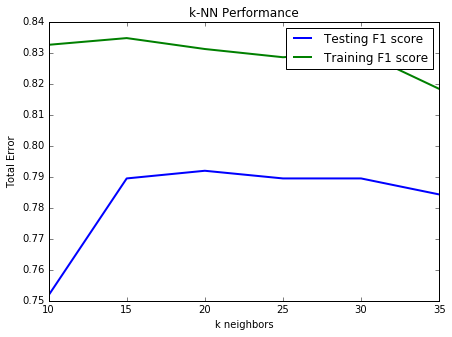

In [35]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as pl
%matplotlib inline

def model_complexity(X_train, y_train, X_test, y_test):
    """ Calculates the performance of the model as model complexity increases.
        The learning and testing errors rates are then plotted. """
    
    print "Creating a model complexity graph. . . "

    # We will vary the number of neighbors from 10 to 40 with step size = 5
    K = np.arange(10, 40, 5)
    train_err = np.zeros(len(K))
    test_err = np.zeros(len(K))

    for i, k in enumerate(K):
        neigh = KNeighborsClassifier(n_neighbors=k)
        train_classifier(neigh, X_train, y_train)
        train_err[i] = predict_labels(neigh, X_train, y_train)
        # Find the performance on the testing set
        test_err[i] = predict_labels(neigh, X_test, y_test)

    # Plot the model complexity graph
    pl.figure(figsize=(7, 5))
    pl.title('k-NN Performance')
    pl.plot(K, test_err, lw=2, label = 'Testing F1 score')
    pl.plot(K, train_err, lw=2, label = 'Training F1 score')
    pl.legend()
    pl.xlabel('k neighbors')
    pl.ylabel('Total Error')
    pl.show()
    
model_complexity(X_train, y_train, X_test, y_test)

- What is the model's final F<sub>1</sub> score?

K = 20, Run 10 Fold Validation and compute the average F1-score: 0.802770241092

In [37]:
#10 Fold validataion
from sklearn.cross_validation import KFold
kf = KFold(n = len(X_all), n_folds=10)
test_err = []
for train_index, test_index in kf:
    X_train, X_test = np.array(X_all)[train_index], np.array(X_all)[test_index]
    y_train, y_test = np.array(y_all)[train_index], np.array(y_all)[test_index]
    neigh = KNeighborsClassifier(n_neighbors=20)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    test_err.append(f1_score(y_test, y_pred, pos_label='yes'))
print np.average(test_err)

0.802770241092
